In [1]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point
import numpy as np
import pandas_profiling
from geopy.distance import great_circle
import numpy as np
import datetime

<b>File Descriptions</b><br><https://www.kaggle.com/c/predict-west-nile-virus/data>
<p><b>train.csv, test.csv</b> - the training and test set of the main dataset. The training set consists of data from 2007, 2009, 2011, and 2013, while in the test set you are requested to predict the test results for 2008, 2010, 2012, and 2014.</p>
<ul>
    <li><b>Id:</b> the id of the record</li>
<li><b>Date:</b> date that the WNV test is performed</li>
<li><b>Address:</b> approximate address of the location of trap. This is used to send to the GeoCoder.</li> 
<li><b>Species:</b> the species of mosquitos</li>
<li><b>Block:</b> block number of address</li>
<li><b>Street:</b> street name</li>
<li><b>Trap:</b> Id of the trap</li>
<li><b>AddressNumberAndStreet:</b> approximate address returned from GeoCoder</li>
<li><b>Latitude, Longitude:</b> Latitude and Longitude returned from GeoCoder</li>
<li><b>AddressAccuracy:</b> accuracy returned from GeoCoder</li>
<li><b>NumMosquitos:</b> number of mosquitoes caught in this trap</li>
<li><b>WnvPresent:</b> whether West Nile Virus was present in these mosquitos. 1 means WNV is present, and 0 means not present.</li>
    </ul>
<p><b>spray.csv</b> - GIS data of spraying efforts in 2011 and 2013</p>
<ul>
<li><b>Date, Time:</b> the date and time of the spray</li>
<li><b>Latitude, Longitude:</b> the Latitude and Longitude of the spray</li>
</ul>
<p><b>weather.csv</b> - weather data from 2007 to 2014. Column descriptions in noaa_weather_qclcd_documentation.pdf.</p>
<p><b>sampleSubmission.csv</b> - a sample submission file in the correct format</p>

In [2]:
train_df = pd.read_csv("../West Nile Virus/predict-west-nile-virus/train.csv")
spray_df = pd.read_csv("../West Nile Virus/predict-west-nile-virus/spray.csv")
weather_df = pd.read_csv("../West Nile Virus/predict-west-nile-virus/weather.csv")

print("Train size: ", train_df.shape)
print("Spray size: ", spray_df.shape)
print("Weather size: ", weather_df.shape)

Train size:  (10506, 12)
Spray size:  (14835, 4)
Weather size:  (2944, 22)


<b>Data Profiling and Exploratory Data Analysis (EDA)</b>

Let's look at what's in each data set using Pandas Profiling.<br> 
<https://www.kaggle.com/nulldata/intro-to-pandas-profiling-simple-fast-eda><br>
<https://en.wikipedia.org/wiki/Exploratory_data_analysis>

<p>Conda installs the 1.41 version of pandas profiling. Current is 2.0 and they haven't updated Conda yet. Beware that some tutorials aren't showing the used version in this project.</p>
<p>Reports are saved in the same folder as .ipynb file</p>

In [3]:
train_profile = pandas_profiling.ProfileReport(train_df)
train_profile.to_file(outputfile="train data profile.html")

spray_profile = pandas_profiling.ProfileReport(spray_df)
spray_profile.to_file(outputfile="spray data profile.html")

weather_profile = pandas_profiling.ProfileReport(weather_df)
weather_profile.to_file(outputfile="weather data profile.html")

C:\Users\Ashley\Anaconda3\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)
C:\Users\Ashley\Anaconda3\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)
C:\Users\Ashley\Anaconda3\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


<b>Converting string/object Dates to datetime types</b><br>
<https://www.datacamp.com/community/tutorials/converting-strings-datetime-objects>
<p>train_df has a categorical field called Species with seven distinct values. We need to change this categorical feature to a binary one with the process called OneHotEncoding.</p>
<p>Let's also change the Date data type from object (string) to datetime64 in train_df, weather_df, and spray_df. This will allow us to use the datetime library on these values</p>

In [4]:
#creating dataframe with binary categorical dummy columns of each species of mosquito
train_encoded_features = pd.get_dummies(train_df['Species'])

#putting new dataframe features into train dataframe
for feature in train_encoded_features:
    train_df[feature] = train_encoded_features[feature]

train_df['Date'] = pd.to_datetime(train_df['Date'])
spray_df['Date'] = pd.to_datetime(spray_df['Date'])
weather_df['Date'] = pd.to_datetime(weather_df['Date'])

<b>Getting Rid of Duplicate Data</b><br>
<https://thispointer.com/pandas-find-duplicate-rows-in-a-dataframe-based-on-all-or-selected-columns-using-dataframe-duplicated-in-python/>
<p>Let's find the duplicate rows for each dataframe and drop them. Looking at the profiles for all three dataframes there seems to be exact duplicates in all of them. We will keep each first occurence and drop the rest.</p>

In [5]:
#duplicate rows except for the first occurence based on all features
train_duplicate = train_df[train_df.duplicated()]
spray_duplicate = spray_df[spray_df.duplicated()]
weather_duplicate = weather_df[weather_df.duplicated()]

#drop duplicates from dataframe
train_df.drop(train_duplicate.index, axis=0, inplace=True)
spray_df.drop(spray_duplicate.index, axis=0, inplace=True)
weather_df.drop(weather_duplicate.index, axis=0, inplace=True)

#print out change of sizes
print("Train Duplicate Count: ", train_duplicate.shape, " Train Size After Duplicate Removal: ", train_df.shape)
print("Spray Duplicate Count: ", spray_duplicate.shape, "  Spray Size After Duplicate Removal: ", spray_df.shape)
print("Weather Duplicate Count: ", weather_duplicate.shape, " Weather Size After Duplicate Removal: ", weather_df.shape)

Train Duplicate Count:  (813, 19)  Train Size After Duplicate Removal:  (9693, 19)
Spray Duplicate Count:  (541, 4)   Spray Size After Duplicate Removal:  (14294, 4)
Weather Duplicate Count:  (0, 22)  Weather Size After Duplicate Removal:  (2944, 22)


<b>Cleaning up Weather Dataframe</b><br><https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.replace.html><br><https://www.thoughtco.com/what-is-trace-of-precipitation-3444238>
<p>weather dataframe has 15 categorical features that need to be converted to numerical/binary</p>
<p>First feature Station needs to be made into binary features. Stations has only two outputs, either station 1 or station2.</p>
<p>Tavg, PrecipTotal, Depart, WetBulb, SnowFall, StnPressure, SeaLevel, Depth, AvgSpeed, Heat, Cool need to be floats.</p>
<p>There are 11 missing datas that have been converted to 0.0 floats in Tavg. To fill in Tavg, we're going to take its corresponding Tmin, Tmax and calculate the Tavg.</p>
<p>Water1 has nothing but missing data and needs to be dropped. There is over 50% data missing for feature CodeSum and it too should be dropped.</p>

In [6]:
#function that changes missing 'M' to 0.0, trace 'T' to '0.005', and anything else to data type float    
def convert_types(feature):
    weather_df[feature] = weather_df[feature].str.replace('M', '0.0')
    weather_df[feature] = weather_df[feature].str.replace('T', '0.005')
    weather_df[feature] = weather_df[feature].astype(float)

#features that represent number measurements but are object data types    
converted_features = ['Tavg', 'PrecipTotal', 'Depart', 'WetBulb', 'SnowFall', 'StnPressure', 'SeaLevel', 'Depth', 'AvgSpeed', 'Heat', 'Cool']    

#convert features
for element in converted_features:
    convert_types(element)

#change the 0.0 Tavg values and calculate a value using corresponding Tmin and Tmax    
weather_df['Tavg'][weather_df.Tavg == 0] = (weather_df['Tmin'] + weather_df['Tmax']) / 2    

weather_df.drop('CodeSum', axis=1, inplace=True)
weather_df.drop('Water1', axis=1, inplace=True)
weather_df.drop('Sunrise', axis=1, inplace=True)
weather_df.drop('Sunset', axis=1, inplace=True)

display(weather_df.columns)

C:\Users\Ashley\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Depth', 'SnowFall', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

<b>Drop Address Related Features from Train Dataframe</b>
<p>We have the exact position with longitude and latitude for all data sets.</p>
<p>So Address, Block, Street, AddressNumberAndStreet, and AddressAccuracy can be dropped.</p>

In [7]:
train_df.drop(['Address','Block','Street','AddressNumberAndStreet','AddressAccuracy'], axis=1, inplace=True)

display(train_df.columns)

Index(['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'NumMosquitos',
       'WnvPresent', 'CULEX ERRATICUS', 'CULEX PIPIENS',
       'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX SALINARIUS',
       'CULEX TARSALIS', 'CULEX TERRITANS'],
      dtype='object')

<b>Merge Train and Weather Dataframes</b><br><https://www.datacamp.com/community/tutorials/joining-dataframes-pandas>
<p>Let's make a unique key value so that we can merge train, weather, and spray dataframes.</p>

<b>Find the nearest Station (in Weather) for each trap location (in Train)</b><br><https://github.com/geopy/geopy><br><https://geopy.readthedocs.io/en/latest/#module-geopy.distance><br><br>
<b>Weather Data</b>

<p>It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet. We provide you with the dataset from NOAA of the weather conditions of 2007 to 2014, during the months of the tests.</p> 

<li>Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level</li>
<li>Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level</li>

<p>Station + Date is being used as a unique key to merging Train and Weather Dataframes</p>

In [8]:
#Longitude and Latitude values for station 1 and station 2
station1Lat = 41.995
station1Long = -87.933
station2Lat = 41.786
station2Long = -87.752

station1_location = (station1Lat, station1Long)
station2_location = (station2Lat, station2Long)

station_closest = []
    
#for loop iterating over train_df and finding the coordinate difference between trap location and each station
#the one with least difference is appended to the list and then added to the train_df dataframe
for index in train_df.index:
    trap_location = (train_df['Latitude'][index], train_df['Longitude'][index])
    if great_circle(trap_location, station1_location).miles < great_circle(trap_location, station2_location).miles:
        station_closest.append(1)
    else:
        station_closest.append(2)
        
#add Station to Train dataframe
train_df['Station'] = station_closest

#Have a unique key that lets Train and Weather merge on the same date and station
train_df['Key'] = train_df['Station'] + train_df['Date']
weather_df['Key'] = weather_df['Station'] + weather_df['Date']

train_weather_merge = pd.merge(train_df, weather_df, on='Key', how='inner')

train_weather_merge.drop('Date_y', axis=1, inplace=True)
train_weather_merge.drop('Station_y', axis=1, inplace=True)

train_weather_merge.rename(columns={'Date_x':'Date', 'Station_x':'Station'}, inplace=True)

In [9]:
display(train_weather_merge.head(3), train_weather_merge.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9693 entries, 0 to 9692
Data columns (total 32 columns):
Date                      9693 non-null datetime64[ns]
Species                   9693 non-null object
Trap                      9693 non-null object
Latitude                  9693 non-null float64
Longitude                 9693 non-null float64
NumMosquitos              9693 non-null int64
WnvPresent                9693 non-null int64
CULEX ERRATICUS           9693 non-null uint8
CULEX PIPIENS             9693 non-null uint8
CULEX PIPIENS/RESTUANS    9693 non-null uint8
CULEX RESTUANS            9693 non-null uint8
CULEX SALINARIUS          9693 non-null uint8
CULEX TARSALIS            9693 non-null uint8
CULEX TERRITANS           9693 non-null uint8
Station                   9693 non-null int64
Key                       9693 non-null datetime64[ns]
Tmax                      9693 non-null int64
Tmin                      9693 non-null int64
Tavg                      9693 non-null f

,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,CULEX ERRATICUS,CULEX PIPIENS,CULEX PIPIENS/RESTUANS,...,Heat,Cool,Depth,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,0,0,1,...,0.0,9.0,0.0,0.0,0.0,29.39,30.11,5.8,18,6.5
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1,0,0,0,0,...,0.0,9.0,0.0,0.0,0.0,29.39,30.11,5.8,18,6.5
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1,0,0,0,0,...,0.0,9.0,0.0,0.0,0.0,29.39,30.11,5.8,18,6.5


None

<b>Spray Data</b>

<p>Each trap is affected by spraying based off time and distance. To create density the traps must be measured from the nearest spray point and then the time difference between when the trap is checked and when the area is spayed must occur. This allows us a change in density of how strongly a trap is affected by spraying.</p> 

Text(0.5, 1, 'Spray and Trap Locations')

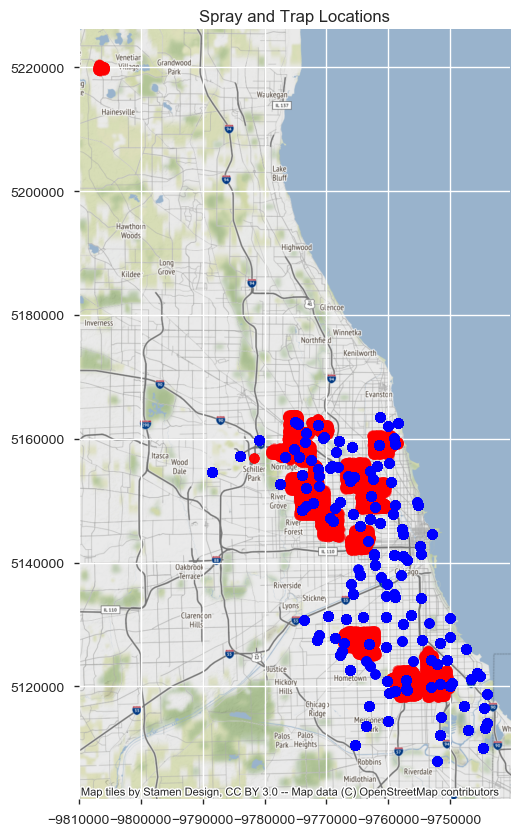

In [10]:
geo_spray_df = gpd.GeoDataFrame(
    spray_df, crs = {'init':'epsg:4326'}, geometry=[Point(x, y) for x, y in zip(spray_df.Longitude, spray_df.Latitude)]).to_crs(epsg=3857)

geo_train_df = gpd.GeoDataFrame(
    train_df, crs = {'init':'epsg:4326'}, geometry=[Point(x, y) for x, y in zip(train_df.Longitude, train_df.Latitude)]).to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))
geo_spray_df.plot(ax=ax, figsize=(10, 10), alpha=0.5, color='red')
geo_train_df.plot(ax=ax, figsize=(10,10), alpha=1, color='blue')
ctx.add_basemap(ax)
plt.title('Spray and Trap Locations')

<b>Finding A Relationship with Train_Weather_Merge Dataframe</b>
<p>Each row in this database shows the location and time of a trap that was checked. Some of these traps are near the location of spraying. Each row on the spray dataframe is of when (date and time) and location of the spray. Let's have an indication of if a trap is near a spray location, how far away, and when that spray occured.</p>
<p>Let's have some binary markers that indicate a general time and place relating the train data with the spray data. In the cell below each lat/long coordinates from each trap check is compared to all of the locations of the sprays. New features will be added to train_weather_merge that are binary features telling us a general location and time of a spray near each trap.</p>

In [11]:
#source: https://stackoverflow.com/a/29546836
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    #km = 6367 * c 
    m = 3957 * c
    return m

In [12]:
import time
start_time = time.time()

train_df['<= 90 days']  = 0
train_df['<= 183 days'] = 0
train_df['<= 365 days'] = 0
train_df['<= 730 days'] = 0
train_df['> 730 days'] = 0

train_df['<= 1/2 mile']  = 0
train_df['<= 1 mile'] = 0
train_df['<= 3 miles'] = 0
train_df['<= 5 miles'] = 0
train_df['> 5 miles'] = 0

#iterrating rows of train_df
for index in train_df.index:
    
    #for each latitude and longitude index a tuple of the two are made
    trap_location = (train_df['Latitude'][index], train_df['Longitude'][index])
    
    #we are taking the difference in test and spray time, converting it from timedelta to float
    #then taking that list and taking all of times that are over zero and putting it into a new list
    temp_time_list = (train_df['Date'][index] - spray_df['Date']).astype('timedelta64[D]') 
    temp_time_list_pruned = temp_time_list[temp_time_list>0]    
    
    #we are taking this new list of positive times and getting a list of booleans that will then be the values of our columns 
    train_df.at[index, '<= 90 days'] = int((temp_time_list_pruned <= 90).any()) 
    train_df.at[index, '<= 183 days'] = int((temp_time_list_pruned <= 183).any())
    train_df.at[index, '<= 365 days'] = int((temp_time_list_pruned <= 365).any())
    train_df.at[index, '<= 730 days'] = int((temp_time_list_pruned <= 730).any())
    train_df.at[index, '> 730 days'] = int((temp_time_list_pruned > 730).any())

    #each trap location is compaired to each latitude and longitude of each spray
    distance_list = haversine_np(spray_df['Longitude'],spray_df['Latitude'], trap_location[1], trap_location[0])
    
    #we are taking this list and creating a new one that has only the distances that correlate with our positive time list
    distance_list_pruned =  distance_list[temp_time_list>0]
    
    #this new list of distances of positive times creates a new list of booleans that are the values of our columns
    train_df.at[index, '<= 1/2 mile'] = int((distance_list_pruned <= 0.5).any())
    train_df.at[index, '<= 1 mile'] = int((distance_list_pruned <= 1).any())
    train_df.at[index, '<= 3 miles'] = int((distance_list_pruned <= 3).any())
    train_df.at[index, '<= 5 miles'] = int((distance_list_pruned <= 5).any())
    train_df.at[index, '> 5 miles'] = int((distance_list_pruned > 5).any())
    
    if index % 500 == 0: print(index)

#shows us the ellapsed time that it takes to run cell
elapsed_time = time.time() - start_time
print("Time: ", elapsed_time/60)

display(train_df.head())

0
500
1500
2000
2500
3000
3500
4000
4500
5500
6000
6500
7000
7500
8000
9000
9500
10000
10500
Time:  1.5254363536834716


,Date,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,CULEX ERRATICUS,CULEX PIPIENS,CULEX PIPIENS/RESTUANS,...,<= 90 days,<= 183 days,<= 365 days,<= 730 days,> 730 days,<= 1/2 mile,<= 1 mile,<= 3 miles,<= 5 miles,> 5 miles
0,2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<p>We're changing the data type for each element in delta_time from timedelta64 to int64 and changing all the negative day values to zero since we are not interested in negative time (the spray happened after the trap check).</p> 

<p>Droping duplicate Features 'Species' and 'Key'.</p>

In [13]:
final_df = pd.concat([train_weather_merge, train_df], axis=1)

print(final_df.columns)

Index(['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'NumMosquitos',
       'WnvPresent', 'CULEX ERRATICUS', 'CULEX PIPIENS',
       'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX SALINARIUS',
       'CULEX TARSALIS', 'CULEX TERRITANS', 'Station', 'Key', 'Tmax', 'Tmin',
       'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Depth',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'Date', 'Species', 'Trap', 'Latitude',
       'Longitude', 'NumMosquitos', 'WnvPresent', 'CULEX ERRATICUS',
       'CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS',
       'CULEX SALINARIUS', 'CULEX TARSALIS', 'CULEX TERRITANS', 'Station',
       'Key', 'geometry', '<= 90 days', '<= 183 days', '<= 365 days',
       '<= 730 days', '> 730 days', '<= 1/2 mile', '<= 1 mile', '<= 3 miles',
       '<= 5 miles', '> 5 miles'],
      dtype='object')


In [14]:
#drop duplicated columns Date, Trap, Latitude, Longitude
final_df = final_df.loc[:,~final_df.columns.duplicated()]

In [15]:
print(final_df.columns)

Index(['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'NumMosquitos',
       'WnvPresent', 'CULEX ERRATICUS', 'CULEX PIPIENS',
       'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX SALINARIUS',
       'CULEX TARSALIS', 'CULEX TERRITANS', 'Station', 'Key', 'Tmax', 'Tmin',
       'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Depth',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'geometry', '<= 90 days', '<= 183 days',
       '<= 365 days', '<= 730 days', '> 730 days', '<= 1/2 mile', '<= 1 mile',
       '<= 3 miles', '<= 5 miles', '> 5 miles'],
      dtype='object')


In [16]:
final_df.drop(['Species', 'Key', 'geometry'], axis=1, inplace=True)

<p>Taking categorical feature stations and making them binary. Then dropping stations.</p>

In [17]:
#creating dataframe with binary categorical dummy columns of each station
station_encoded_features = pd.get_dummies(final_df['Station'])

#putting new dataframe features into train dataframe
for feature in station_encoded_features:
    final_df[feature] = station_encoded_features[feature]

final_df.drop('Station', axis=1, inplace=True)

In [18]:
display(final_df, final_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10496 entries, 0 to 10505
Data columns (total 41 columns):
Date                      9693 non-null datetime64[ns]
Trap                      9693 non-null object
Latitude                  9693 non-null float64
Longitude                 9693 non-null float64
NumMosquitos              9693 non-null float64
WnvPresent                9693 non-null float64
CULEX ERRATICUS           9693 non-null float64
CULEX PIPIENS             9693 non-null float64
CULEX PIPIENS/RESTUANS    9693 non-null float64
CULEX RESTUANS            9693 non-null float64
CULEX SALINARIUS          9693 non-null float64
CULEX TARSALIS            9693 non-null float64
CULEX TERRITANS           9693 non-null float64
Tmax                      9693 non-null float64
Tmin                      9693 non-null float64
Tavg                      9693 non-null float64
Depart                    9693 non-null float64
DewPoint                  9693 non-null float64
WetBulb              

,Date,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,CULEX ERRATICUS,CULEX PIPIENS,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,...,<= 365 days,<= 730 days,> 730 days,<= 1/2 mile,<= 1 mile,<= 3 miles,<= 5 miles,> 5 miles,1.0,2.0
0,2007-05-29,T002,41.954690,-87.800991,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
1,2007-05-29,T002,41.954690,-87.800991,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2,2007-05-29,T007,41.994991,-87.769279,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
3,2007-05-29,T015,41.974089,-87.824812,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
4,2007-05-29,T015,41.974089,-87.824812,4.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0,0
10502,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0
10503,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0,0
10504,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0


None

In [19]:
#drop all rows with missing values
final_df = final_df.dropna()
final_df = final_df.reset_index(drop=True)

In [20]:
display(final_df)

,Date,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,CULEX ERRATICUS,CULEX PIPIENS,CULEX PIPIENS/RESTUANS,CULEX RESTUANS,...,<= 365 days,<= 730 days,> 730 days,<= 1/2 mile,<= 1 mile,<= 3 miles,<= 5 miles,> 5 miles,1.0,2.0
0,2007-05-29,T002,41.954690,-87.800991,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
1,2007-05-29,T002,41.954690,-87.800991,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2,2007-05-29,T007,41.994991,-87.769279,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
3,2007-05-29,T015,41.974089,-87.824812,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
4,2007-05-29,T015,41.974089,-87.824812,4.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8885,2013-09-26,T230,41.904194,-87.756155,13.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0,1
8886,2013-09-26,T230,41.904194,-87.756155,5.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0,1
8887,2013-09-26,T035,41.763733,-87.742302,6.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0,1
8888,2013-09-26,T232,41.912563,-87.668055,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,1


<b>Export final database to CSV File for Easy Access</b>

In [21]:
final_df.to_csv('final_df.csv', index=False)